In [1]:
import os
import sys
import tensorflow as tf
import numpy      as np

In [2]:
InputFile      = '../input/O3_UMN/'


WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
SurQCTFldr     = WORKSPACE_PATH + '/SurQCT/surqct/'

print("\n======================================================================================================================================")
print(" TensorFlow version: {}".format(tf.__version__))
print(" Eager execution: {}".format(tf.executing_eagerly()))


 TensorFlow version: 2.4.1
 Eager execution: True


In [3]:
##==============================================================================================================
print("\n[SurQCT]: Loading Modules and Functions ...")

sys.path.insert(0, SurQCTFldr  + '/src/Reading/')
# from Reading import read_data, read_losseshistory
sys.path.insert(0, SurQCTFldr  + '/src/Plotting/')
from Plotting import plot_losseshistory
# sys.path.insert(0, SurQCTFldr  + '/src/Saving/')
# from Saving import save_parameters, save_data


InputFile = '../input/O3_UMN/'
print("[SurQCT]:   Calling SurQCT with Input File = ", InputFile)
sys.path.insert(0, InputFile)
##--------------------------------------------------------------------------------------------------------------


##==============================================================================================================
print("\n[SurQCT]: Keep Loading Modules and Functions...")
from SurQCT_Input import inputdata

print("\n[SurQCT]: Initializing Input ...")
InputData    = inputdata(WORKSPACE_PATH, SurQCTFldr)
##--------------------------------------------------------------------------------------------------------------


##==============================================================================================================
print("\n[SurQCT]: Loading Final Modules ... ")

sys.path.insert(0, SurQCTFldr  + '/src/Model/' + InputData.ApproxModel + '/')
from Model import model
# if (InputData.ApproxModel == 'FNN'):
#     from Model import FNN

sys.path.insert(0, SurQCTFldr  + '/src/RatesType/' + InputData.RatesType + '/')
from RatesType import generate_data
# Generating Data
InputData, TrainData, TestData, AllData = generate_data(InputData)
##--------------------------------------------------------------------------------------------------------------


PathToFldr = InputData.PathToRunFld
try:
    os.makedirs(PathToFldr)
except OSError as e:
    pass


[SurQCT]: Loading Modules and Functions ...
[SurQCT]:   Calling SurQCT with Input File =  ../input/O3_UMN/

[SurQCT]: Keep Loading Modules and Functions...

[SurQCT]: Initializing Input ...

[SurQCT]: Loading Final Modules ... 


In [4]:
### Initializing the Surrogate Model
NN = model(InputData, TrainData)

### Training the Surrogate Model
if (InputData.TrainIntFlg >= 1):
    History = NN.train(InputData)


[ProPDE]: Loading Data ... 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 10)                21        
_________________________________________________________________
HL1 (Dense)                  (None, 64)                704       
_________________________________________________________________
HL2 (Dense)                  (None, 64)                4160      
_________________________________________________________________
OL (Dense)                   (None, 1)                 65        
Total params: 4,950
Trainable params: 4,929
Non-trainable params: 21
_________________________________________________________________
xTrain =          EVib_1    ERot_1    rMin_1     rMax_1    VMin_1    VMax_1       Tau_1  \
445  -3.820550  0.004930  2.282276  14.660615 -5.205839  0.000090   982.64917   
5043 -2.368836  2.680959  2.452142   4.227645 -1.8

221/221 [==============================] - 0s 885us/step - loss: 0.2178 - val_loss: 0.1894
Epoch 52/300
221/221 [==============================] - 0s 858us/step - loss: 0.2061 - val_loss: 0.2097
Epoch 53/300
221/221 [==============================] - 0s 885us/step - loss: 0.2130 - val_loss: 0.1893
Epoch 54/300
221/221 [==============================] - 0s 880us/step - loss: 0.1939 - val_loss: 0.1929
Epoch 55/300
221/221 [==============================] - 0s 872us/step - loss: 0.2187 - val_loss: 0.1894
Epoch 56/300
221/221 [==============================] - 0s 908us/step - loss: 0.2044 - val_loss: 0.1844
Epoch 57/300
221/221 [==============================] - 0s 881us/step - loss: 0.2207 - val_loss: 0.1864
Epoch 58/300
221/221 [==============================] - 0s 895us/step - loss: 0.2251 - val_loss: 0.1951
Epoch 59/300
221/221 [==============================] - 0s 870us/step - loss: 0.2220 - val_loss: 0.1887
Epoch 60/300
221/221 [==============================] - 0s 876us/step - loss:

221/221 [==============================] - 0s 925us/step - loss: 0.1956 - val_loss: 0.1711
Epoch 130/300
221/221 [==============================] - 0s 892us/step - loss: 0.2047 - val_loss: 0.1886
Epoch 131/300
221/221 [==============================] - 0s 917us/step - loss: 0.1971 - val_loss: 0.1748
Epoch 132/300
221/221 [==============================] - 0s 886us/step - loss: 0.2010 - val_loss: 0.1737
Epoch 133/300
221/221 [==============================] - 0s 893us/step - loss: 0.1884 - val_loss: 0.1731
Epoch 134/300
221/221 [==============================] - 0s 899us/step - loss: 0.1999 - val_loss: 0.1700
Epoch 135/300
221/221 [==============================] - 0s 880us/step - loss: 0.2146 - val_loss: 0.1715
Epoch 136/300
221/221 [==============================] - 0s 897us/step - loss: 0.2056 - val_loss: 0.1811
Epoch 137/300
221/221 [==============================] - 0s 887us/step - loss: 0.1858 - val_loss: 0.1760
Epoch 138/300
221/221 [==============================] - 0s 902us/ste

221/221 [==============================] - 0s 943us/step - loss: 0.2013 - val_loss: 0.1775
Epoch 208/300
221/221 [==============================] - 0s 887us/step - loss: 0.1889 - val_loss: 0.1785
Epoch 209/300
221/221 [==============================] - 0s 885us/step - loss: 0.2272 - val_loss: 0.1672
Epoch 210/300
221/221 [==============================] - 0s 903us/step - loss: 0.1687 - val_loss: 0.1749
Epoch 211/300
221/221 [==============================] - 0s 923us/step - loss: 0.1806 - val_loss: 0.1730
Epoch 212/300
221/221 [==============================] - 0s 932us/step - loss: 0.1781 - val_loss: 0.1705
Epoch 213/300
221/221 [==============================] - 0s 928us/step - loss: 0.2000 - val_loss: 0.1720
Epoch 214/300
221/221 [==============================] - 0s 878us/step - loss: 0.1962 - val_loss: 0.1778
Epoch 215/300
221/221 [==============================] - 0s 881us/step - loss: 0.1842 - val_loss: 0.1735
Epoch 216/300
221/221 [==============================] - 0s 883us/ste

221/221 [==============================] - 0s 894us/step - loss: 0.1928 - val_loss: 0.1682
Epoch 286/300
221/221 [==============================] - 0s 886us/step - loss: 0.1907 - val_loss: 0.1689
Epoch 287/300
221/221 [==============================] - 0s 880us/step - loss: 0.1942 - val_loss: 0.1707
Epoch 288/300
221/221 [==============================] - 0s 873us/step - loss: 0.1806 - val_loss: 0.1666
Epoch 289/300
221/221 [==============================] - 0s 917us/step - loss: 0.1932 - val_loss: 0.1677
Epoch 290/300
221/221 [==============================] - 0s 879us/step - loss: 0.2009 - val_loss: 0.1707
Epoch 291/300
221/221 [==============================] - 0s 873us/step - loss: 0.1812 - val_loss: 0.1807
Epoch 292/300
221/221 [==============================] - 0s 906us/step - loss: 0.1913 - val_loss: 0.1656
Epoch 293/300
221/221 [==============================] - 0s 931us/step - loss: 0.1815 - val_loss: 0.1683
Epoch 294/300
221/221 [==============================] - 0s 907us/ste

In [5]:
plot_losseshistory(InputData, History)

1500.0
0        True
1        True
2        True
3        True
4        True
        ...  
6110    False
6111    False
6112    False
6113    False
6114    False
Name: TTran, Length: 61150, dtype: bool


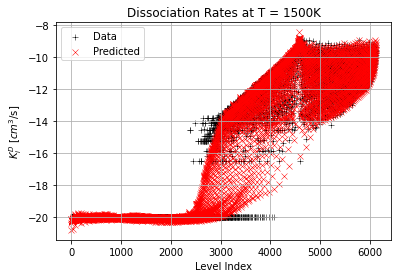

2500.0
0       False
1       False
2       False
3       False
4       False
        ...  
6110    False
6111    False
6112    False
6113    False
6114    False
Name: TTran, Length: 61150, dtype: bool


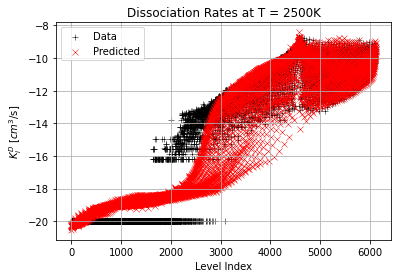

5000.0
0       False
1       False
2       False
3       False
4       False
        ...  
6110    False
6111    False
6112    False
6113    False
6114    False
Name: TTran, Length: 61150, dtype: bool


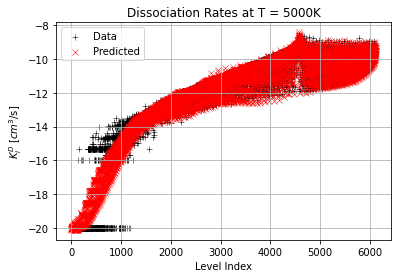

6000.0
0       False
1       False
2       False
3       False
4       False
        ...  
6110    False
6111    False
6112    False
6113    False
6114    False
Name: TTran, Length: 61150, dtype: bool


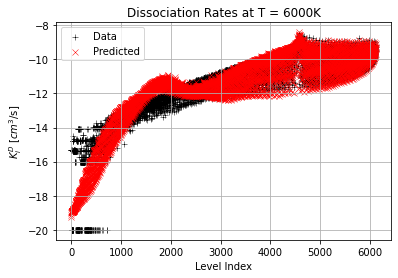

8000.0
0       False
1       False
2       False
3       False
4       False
        ...  
6110    False
6111    False
6112    False
6113    False
6114    False
Name: TTran, Length: 61150, dtype: bool


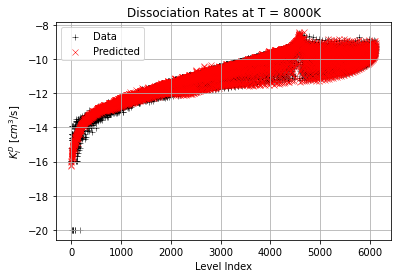

10000.0
0       False
1       False
2       False
3       False
4       False
        ...  
6110    False
6111    False
6112    False
6113    False
6114    False
Name: TTran, Length: 61150, dtype: bool


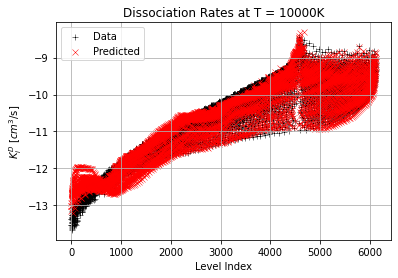

12000.0
0       False
1       False
2       False
3       False
4       False
        ...  
6110    False
6111    False
6112    False
6113    False
6114    False
Name: TTran, Length: 61150, dtype: bool


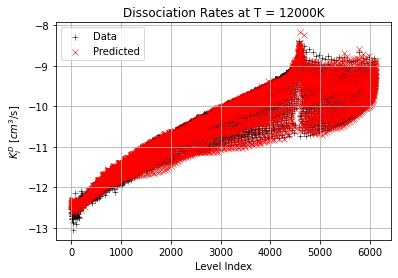

14000.0
0       False
1       False
2       False
3       False
4       False
        ...  
6110    False
6111    False
6112    False
6113    False
6114    False
Name: TTran, Length: 61150, dtype: bool


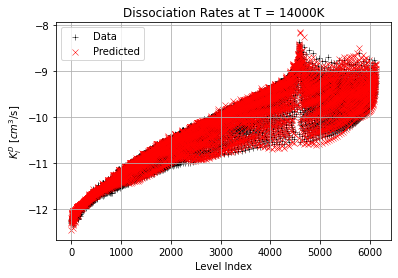

15000.0
0       False
1       False
2       False
3       False
4       False
        ...  
6110    False
6111    False
6112    False
6113    False
6114    False
Name: TTran, Length: 61150, dtype: bool


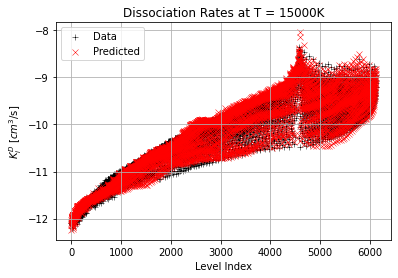

20000.0
0       False
1       False
2       False
3       False
4       False
        ...  
6110     True
6111     True
6112     True
6113     True
6114     True
Name: TTran, Length: 61150, dtype: bool


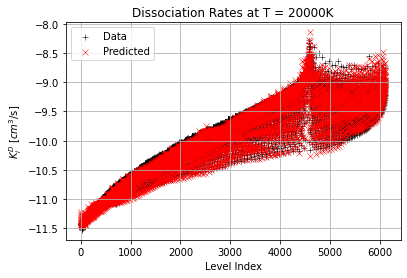

In [7]:
%matplotlib inline
### Generating Test Results
if (InputData.TestIntFlg >= 1):
    xAll   = AllData[0]
    yAll   = AllData[1]
    xExtra = ExtraData


    for TTran in InputData.TTranVecTest:
        MaskVec = (xAll['TTran'] == TTran)
        xPred   = xAll.loc[MaskVec]
        yPred   = NN.Model.predict(xPred)
        yData   = yAll.loc[MaskVec]

        ### Plotting Test Results
        if (InputData.PlotIntFlg >= 1):

            PathToFldr = InputData.PathToFigFld
            try:
                os.makedirs(PathToFldr)
            except OSError as e:
                pass
            NN.plot_prediction(InputData, yData, yPred, TTran)


    for TTran in InputData.TTranVecExtra:
        MaskVec = (xExtra['TTran'] == TTran)
        xPred   = xExtra.loc[MaskVec]
        yPred   = NN.Model.predict(xPred)
        yData   = []

        ### Plotting Test Results
        if (InputData.PlotIntFlg >= 1):

            PathToFldr = InputData.PathToFigFld
            try:
                os.makedirs(PathToFldr)
            except OSError as e:
                pass
            NN.plot_prediction(InputData, yData, yPred, TTran)

,EVib_1,ERot_1,rMin_1,rMax_1,VMin_1,VMax_1,Tau_1,ri_1,ro_1,TTran
0,-5.113043,0.000000,2.282050,100.000000,-5.211216,0.000000,873.99366,2.190762,2.385961,8000.0
1,-5.113043,0.000356,2.282065,27.033512,-5.210858,0.000002,874.01142,2.190776,2.385977,8000.0
2,-5.113043,0.001069,2.282096,21.162580,-5.210141,0.000009,874.04694,2.190805,2.386010,8000.0
3,-5.113043,0.002138,2.282141,18.060679,-5.209065,0.000024,874.10024,2.190847,2.386058,8000.0
4,-5.113043,0.003563,2.282201,16.072384,-5.207631,0.000050,874.17131,2.190904,2.386123,8000.0
...,...,...,...,...,...,...,...,...,...,...
6110,-4.919035,7.999146,2.978033,3.600799,2.978736,3.136510,2708.61700,2.753143,3.337746,8000.0
6111,-4.728227,7.819587,2.967048,3.611121,2.928445,3.102337,3502.51400,2.696988,3.513084,8000.0
6112,-5.113043,8.223681,3.001101,3.579126,3.078809,3.205899,2498.33140,2.857634,3.186316,8000.0
6113,-4.919035,8.046349,2.989371,3.590147,3.028861,3.171028,2831.85770,2.763864,3.359623,8000.0
